# Feature Selection

Features that would be hard to measure: lambda_30, lamda_40, s, Delta_T, nu, Q_p

Easy: wind, Hs, p, swell, kh, T_air, L_deep, T_p, Delta_p_1h, 

## Setup

Importing all required packages and define seed and number of cores to use.

In [7]:
import os
import pandas as pd
import numpy as np
import sys
import pickle

import matplotlib.pyplot as plt

sys.path.append('./')
import utils

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold


In [8]:
print(os.cpu_count()) # how many CPU cores are available on the current machine

256


In [9]:
seed = 42
n_jobs = 4

In [10]:
case = 3
undersample = True
num_cv = 10

## Load the Data

In [11]:
# Load and unpack the data
with open(f'../data/data_case{case}{"_undersampled" if undersample else ""}.pickle', 'rb') as handle:
    data = pickle.load(handle)

data_train, data_test = data
y_train = data_train['AI_10min']
y_train_cat = data_train['AI_10min_cat']
X_train = data_train.drop(columns=['AI_10min', 'AI_10min_cat'])
y_test = data_test['AI_10min']
X_test = data_test.drop(columns=['AI_10min', 'AI_10min_cat'])

Check the correlation matrix to see if we have redundant features.

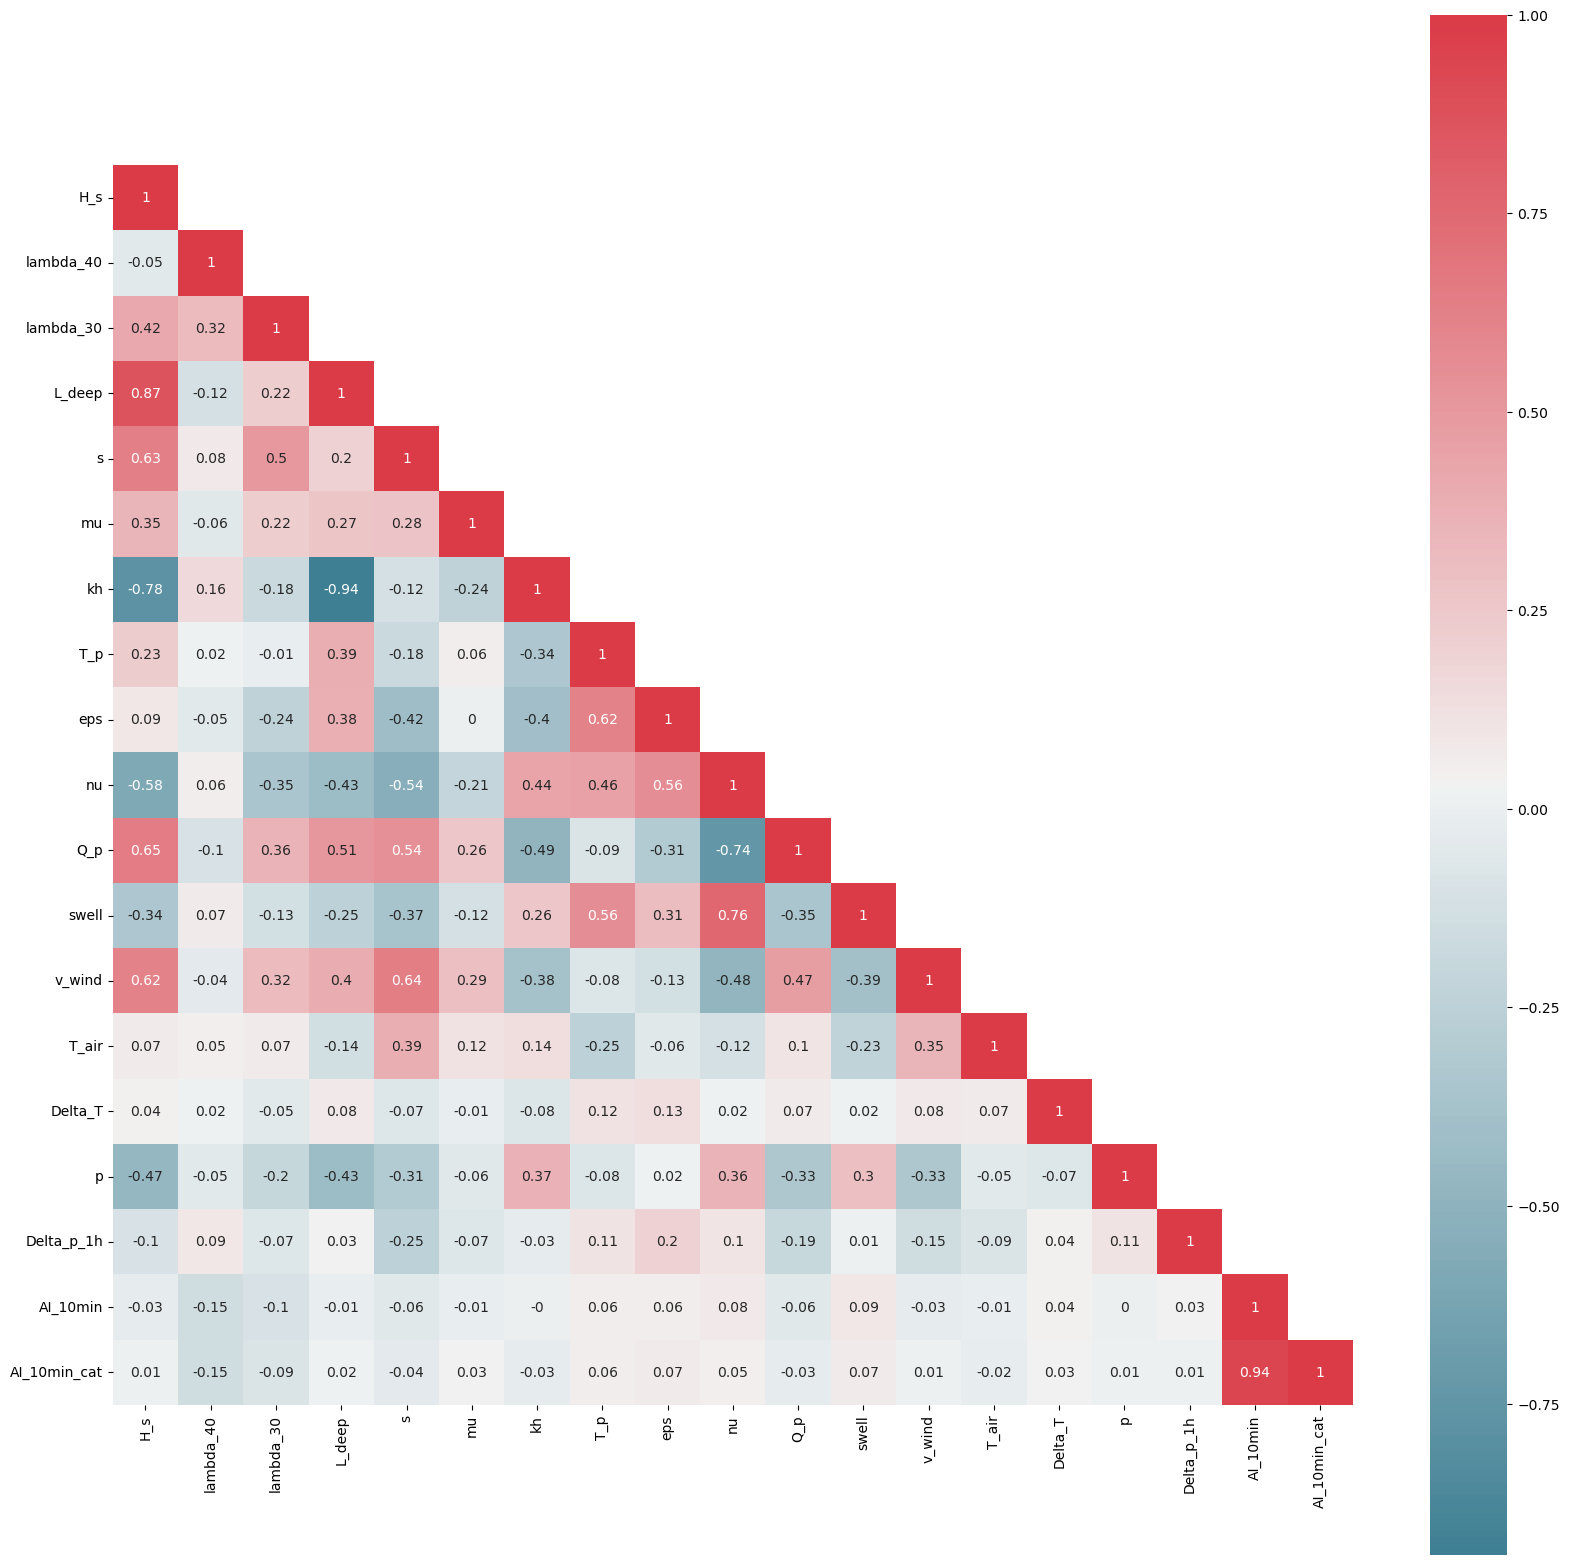

In [6]:
utils.plot_correlation_matrix(data_train, figsize=(20, 20), annot=True, labelsize=10)

## Feature Selection

In [12]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
max_depth = 30
criterion = "friedman_mse"
max_features = "sqrt"

model = RandomForestRegressor(oob_score=True, random_state=seed, n_estimators=1000, max_depth=max_depth, max_samples=0.8, criterion=criterion, max_features=max_features)

### Feature Selection with Recursive Feature Elimination

A Recursive Feature Elimination (RFE) example with automatic tuning of the number of features selected with cross-validation.  
For further information see:
- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
- https://medium.com/@loyfordmwenda/recursive-feature-rfe-elimination-with-scikit-learn-d0d29e96273d

In [ ]:
# Define the RFE parameters
min_features_to_select = 1  # Minimum number of features to consider
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=skf,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=n_jobs,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()


### Sequential Feature Selection

SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.  
For further information see:

- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py


In [ ]:
tol = 0.05 # we use the r^2 score for a RandomForest Regressor
n_features_to_select = "auto"
direction = "forward"
scoring = "r2"

In [ ]:
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)
sfs = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, tol=tol, direction=direction, scoring=scoring, cv=skf)
sfs.fit(X_train, y_train)

print(f"Optimal number of features: {sfs.n_features_to_select_}")
print(f"Selected features: {X_train.columns[sfs.support_]}")